In [1]:
%matplotlib inline


# PyTorch Implementation of "Generative Modeling using the Sliced Wasserstein Distance"
 <http://openaccess.thecvf.com/content_cvpr_2018/papers/Deshpande_Generative_Modeling_Using_CVPR_2018_paper.pdf>

Ishan Deshpande, Ziyu Zhang, Alexander G. Schwing; The IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2018, pp. 3483-3491

The implementation is done by Fehmi Kahraman (Department of Computer Engineering, Middle East Technical University)


### Summary of the paper


Generative Adversarial Networks (GANs) have some challenges such as mode dropping, vanishing gradients, training instability, and sensitivity to parameter initialization. To address some of these challenges, especially vanishing  gradients, Arjovsky et al.**[1]** introduced Wasserstein GAN (WGAN) based on the Wasserstein distance rather than the Jenson-Shannon divergence. In this paper, Deshpande et al. improve the stability of WGAN training by developing a mechanism based on random projections instead of using the Kantorovich-Rubinstein duality.

### The proposed approach with sliced Wasserstein distance

Wasserstein distance is a distance metric between two datasets containing real data points $ x \in D$, and generated samples $ \hat{x} = G_\theta(z) \in F$.  

$ W_2^2(D,F)$ shows quadratic Wasserstein distance between two sets of data points $D$ and $F$.
Denoting that $\omega$ is possible directions on the unit sphere $\Omega$  ($\omega \in \Omega$), $D^\omega and F^\omega$ contain 1-dimensional projections onto direction $\omega$, the optimization is formulated as follows:

$$ \min_{\theta} \frac{1}{|\hat{\Omega}|} \sum_{\omega \in \hat{\Omega}} W_2^2(D^\omega, F^\omega(\theta)) $$


The proposed approach is summarized in **Alg.1.** in the paper.


<span style="font-size:14px">
[1] M. Arjovsky, S. Chintala, and L. Bottou. Wasserstein gan.
arXiv preprint arXiv:1701.07875, 2017.
</span>

### Tested with

python 3.8.2

pytorch 1.5.0

numpy 1.18.1

matplotlib 3.1.3

torchvision 0.6.0

cuda 10.2


In [2]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets 
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt



# run cuda if available
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

seed = random.randint(1, 100)
print("Random Seed: ", seed)
torch.manual_seed(seed)
np.random.seed(seed)

Random Seed:  31


### Assign data and output directories

- **run_on** - Please assign "local" to run on a local machine or "colab" to run on Google Colaboratory. We had to run it on colab due to insufficient GPU on local machine

In [3]:
# "local" or "colab"
run_on = "local"

#Directory containing training data
datadir="data"
if not os.path.exists(datadir):
  os.makedirs(datadir)
  
if run_on == "local":
  #Directory to save output
  out_file= 'results'
  if not os.path.exists(out_file):
    os.makedirs(out_file)
elif run_on=="colab":
  out_file="/content/drive/My Drive"
  #we need to mount Google Drive to Google Colaboratory
  from google.colab import drive
  drive.mount('/content/drive')


## Task 1: Train model and generate samples on CIFAR10 dataset.

The paper gives information about base architecture in **Section 4.4** as follows:

"The base architecture for both the generator and discriminator is the **DCGAN** **[29]**. Like **[9]** we use layer normalization **[3]** in the discriminator. We make modifications to this, for instance using twice as many filters in each layer of the discriminator, or using a constant 64 filters in every layer. We also test a deeper generator by adding 2 convolutional layers of stride 1 for one experiment."

Since DCGAN implementation is beyond the scope of this paper, I utilized from the dcgan code in <https://github.com/pytorch/examples/tree/master/dcgan> .

<span style="font-size:14px">
[29] A. Radford, L. Metz, and S. Chintala. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434, 2015. <br>
[9] I. Gulrajani, F. Ahmed, M. Arjovsky, V. Dumoulin, and A. Courville. Improved training of wasserstein gans. arXiv preprint arXiv:1704.00028, 2017. <br>
[3] J. L. Ba, J. R. Kiros, and G. E. Hinton. Layer normalization. arXiv preprint arXiv:1607.06450, 2016.
</span>


**Difficulties Encountered**:
1. The model  architecture expressed in DCGAN paper is based on 64X64 image size. In our article, it is not clear how it is implemented on CIFAR10 dataset 32X32. We modified the architecture to fit the 32X32 image size.
2. Initialization is applied according to DCGAN paper since weight initialization is not mentioned in the paper.


### Hyperparameters

In [4]:
#batch size used in training. The paper uses a batch size of 64
batch_size = 64
#image width/height
image_size=32
#number of color channel
num_channel = 3
#the depth of feature maps for generator
gen_n_f = 64
#the depth of feature maps for discriminator
disc_n_f = 64
#number of training epochs to run
num_epochs = 26
#learning rate for training. As described in the paper, this number is 0.0001
lr = 0.0001
#beta1 hyperparameter for Adam optimizers. As described in the paper, this number is 0.5
beta1 = 0.5
#length of latent vector z, noise
dim_z = 100
#number of projections for sliced wasserstein distance. As described in the paper, this number is 10000
num_projections=10000

### Training Data

The CIFAR-10 training dataset can be downloaded ( the file size is 170 MB). Image is shifted to the range (-1,1).

In [5]:
dataset = torchvision.datasets.CIFAR10(root=datadir, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

Files already downloaded and verified


### Weight initialization

Initialization is applied according to DCGAN paper since weight initialization is not mentioned in the paper.

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Modified DCGAN Generator
DCGAN Generator is modified for CIFAR10 image size(32x32).

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        
        self.layer1=nn.Sequential(
            nn.Linear(dim_z, 4*4*gen_n_f*4),
            nn.BatchNorm1d(4*4*gen_n_f*4),
            nn.ReLU(True)
        )
        # 256 x 4 x 4
        self.layer2= nn.Sequential(
            nn.ConvTranspose2d( gen_n_f*4, gen_n_f*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(gen_n_f * 2),
            nn.ReLU(True)
            # 128 x 8 x 8
        )
        self.layer3= nn.Sequential(
            nn.ConvTranspose2d(gen_n_f*2, gen_n_f, 4, stride=2, padding=1),
            nn.BatchNorm2d(gen_n_f ),
            nn.ReLU(True),
            # 64 x 16 x 16
        )
        
        self.layer4= nn.Sequential(
            nn.ConvTranspose2d( gen_n_f, num_channel, 4, stride=2, padding=1),
            nn.Tanh()
            # 3 x 32 x 32
        )
        

    def forward(self, z):
        output=self.layer1(z)
        output=self.layer2(output.view(-1,gen_n_f*4,4,4))
        output=self.layer3(output)
        output=self.layer4(output)
        return output

We can instantiate the generator and apply the ``weights_init`` function. Check out the printed model to see how the generator object is structured.

In [8]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)


### Sliced Wasserstein distance loss for Generator

According to Alg.1. in the paper, this function projects the samples onto random directions $\omega$, sorts the projected sets and then computes Wasserstein distance.

L2 normalization is not mentioned in the paper. After implementing the function, we checked the official tensorflow implementation of the paper and added L2 normalization.


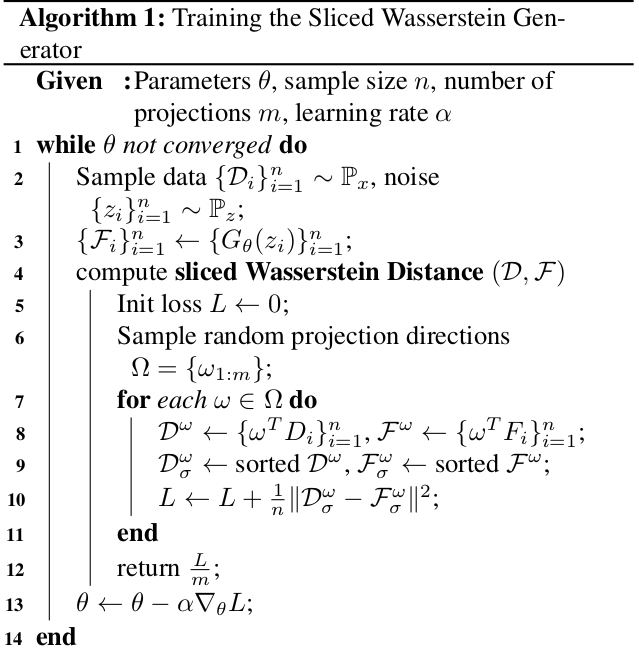

In [9]:
def swd_loss(real_dist, fake_dist):
  
  b_size = real_dist.size(0)
  #feature dimension
  dimension= real_dist.size(-1)
  #sample random projection directions (Gaussian dist.) Section 3
  #omega [feature,10000]
  omega = torch.randn((dimension, num_projections), device=device)
  #L2 normalization is not mentioned in the paper.
  omega = nn.functional.normalize(omega, p=2, dim=0)

  #project onto images.  [batch_size,10000] (10000 projections for each image)
  projected_real= torch.matmul(real_dist,omega)
  projected_fake= torch.matmul(fake_dist, omega)
  #sort along the first dimension (batch size)
  sorted_real = torch.sort(projected_real, dim=0)[0]
  sorted_fake = torch.sort(projected_fake, dim=0)[0]

  distance=sorted_real-sorted_fake

  loss = distance.pow(2).mean()

  return loss

### Modified DCGAN Discriminator
DCGAN Discriminator is modified just like the Generator for the CIFAR10 image size.


In the discriminator, layer normalization is used instead of batch normalization according to Section 4.3 in the paper.

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layer1=nn.Sequential(
            nn.Conv2d(num_channel, disc_n_f, 4, stride=2, padding=1),
            nn.LayerNorm([disc_n_f,16,16]),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
        )
        self.layer2= nn.Sequential(
            nn.Conv2d( disc_n_f, disc_n_f * 2, 4, stride=2, padding=1),
            nn.LayerNorm([disc_n_f*2,8,8]),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
        )
        self.layer3= nn.Sequential(
            nn.Conv2d(disc_n_f * 2, disc_n_f * 4, 4, stride=2, padding=1),
            nn.LayerNorm([disc_n_f*4,4,4]),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
        )
        
        self.layer4= nn.Sequential(
            nn.Linear( disc_n_f*4*4*4, 1, False),
            nn.Sigmoid()
        )

    def forward(self, x):
        h=self.layer1(x)
        h=self.layer2(h)
        h=self.layer3(h)
        feature_disc=h.view(x.size(0), -1)
        prob=self.layer4(feature_disc)
        return prob.view(-1), feature_disc

We can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [12]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)


Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LayerNorm((128, 8, 8), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LayerNorm((256, 4, 4), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=False)
    (1): Sigmoid()
  )
)


### Optimizers and discriminator loss



In [13]:
disc_criterion = nn.BCELoss()

# real and fake labels during training
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**Plot Generator Loss of pre-trained model**

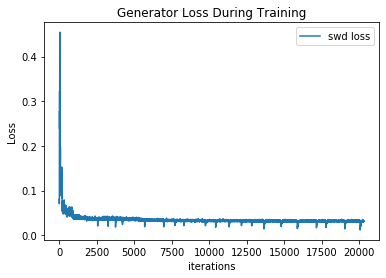

In [15]:
G_losses= torch.load(f"{out_file}/G_losses.pt")

plt.figure()
plt.title("Generator Loss During Training")
plt.plot(G_losses,label="swd loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Compare real images and fake images generated from pre-trained model**

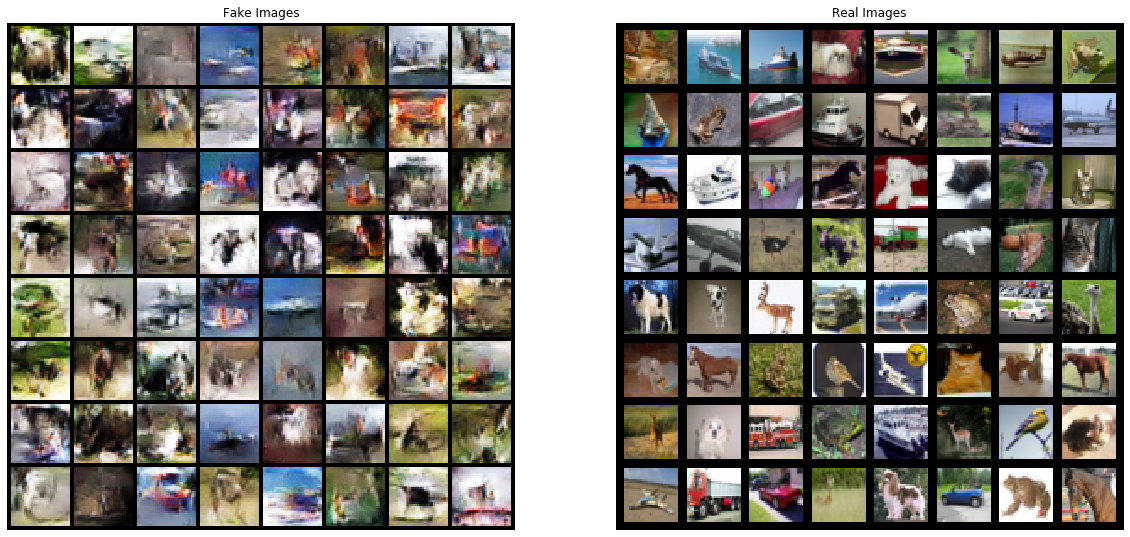

In [14]:
pathG_load= f"{out_file}/netG_epoch_26.pth"  
netG.load_state_dict(torch.load(pathG_load))
netG.eval()

fixed_noise = torch.FloatTensor(batch_size,dim_z).uniform_(-1, 1).to(device)            
images_toshow=[]       
with torch.no_grad():
  fake = netG(fixed_noise).detach().cpu()
  images_toshow.append(vutils.make_grid(fake, padding=2, normalize=True))

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(images_toshow[-1],(1,2,0)))

real_batch = next(iter(dataloader))

# Plot the real images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

### Training
We trained the model for 26 epochs, which approximately equals 20K iterations (20306), as in the paper. At the end of the training, we saved the model state, image samples and loss values of generator and discriminator.


In [0]:
G_losses = []
D_losses = []
iters=0
img_list = []


print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
      real_input = data[0].to(device)
      b_size=real_input.size(0)
      # make sure batch size is same; otherwise, it leads swd_loss oscillate
      if b_size == batch_size:
        optimizerD.zero_grad()
        real_output, _ = netD(real_input)
        # label 1 for real inputs
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        errD_real = disc_criterion(real_output, label)
        errD_real.backward()
    
        noise = torch.FloatTensor(b_size,dim_z).uniform_(-1, 1).to(device)
        fake = netG(noise).detach()
        fake_output, _ = netD(fake)
        # label zero for fake
        label.fill_(fake_label)
        errD_fake = disc_criterion(fake_output, label)
        errD_fake.backward()
        errD = (errD_real + errD_fake).mean()
        optimizerD.step()
        
        netG.train()
        optimizerG.zero_grad()
        fake = netG(noise)
        _, d_fake_feature= netD(fake)
        _, d_real_feature=netD(real_input)
        #compute sliced wesserstein distance loss
        errG = swd_loss(d_real_feature.detach(), d_fake_feature)
        errG.backward()
        optimizerG.step()

        # Output training stats
        if iters % 250 == 0:
            print('[%d/%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f '
                  % (epoch+1, num_epochs, iters,
                     errD.item(), errG.item()))
            
        G_losses.append(errG.item())
        D_losses.append(errD.item())
            
        
        fixed_noise = torch.FloatTensor(batch_size,dim_z).uniform_(-1, 1).to(device)
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-2)):
          with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters+=1

    if epoch==num_epochs-1:
        torch.save(netG.state_dict(), f"{out_file}/netG_epoch_{epoch+1}.pth")
        torch.save(netD.state_dict(), f"{out_file}/netD_epoch_{epoch+1}.pth")

torch.save(G_losses, f"{out_file}/G_losses.pt")
torch.save(D_losses, f"{out_file}/D_losses.pt")
torch.save(img_list, f"{out_file}/img_list.pt")


Starting Training Loop...
[1/26][0]	Loss_D: 1.4079	Loss_G: 0.0810 
[1/26][250]	Loss_D: 0.3870	Loss_G: 0.0543 
[1/26][500]	Loss_D: 0.6531	Loss_G: 0.0487 
[1/26][750]	Loss_D: 0.2779	Loss_G: 0.0483 
[2/26][1000]	Loss_D: 0.4075	Loss_G: 0.0379 
[2/26][1250]	Loss_D: 0.3146	Loss_G: 0.0400 
[2/26][1500]	Loss_D: 0.3451	Loss_G: 0.0367 
[3/26][1750]	Loss_D: 0.2972	Loss_G: 0.0376 
[3/26][2000]	Loss_D: 0.2318	Loss_G: 0.0369 
[3/26][2250]	Loss_D: 0.4467	Loss_G: 0.0348 
[4/26][2500]	Loss_D: 0.6377	Loss_G: 0.0336 
[4/26][2750]	Loss_D: 0.1905	Loss_G: 0.0396 
[4/26][3000]	Loss_D: 0.3187	Loss_G: 0.0373 
[5/26][3250]	Loss_D: 0.7181	Loss_G: 0.0346 
[5/26][3500]	Loss_D: 0.1698	Loss_G: 0.0366 
[5/26][3750]	Loss_D: 2.7991	Loss_G: 0.0228 
[6/26][4000]	Loss_D: 0.1868	Loss_G: 0.0375 
[6/26][4250]	Loss_D: 0.2315	Loss_G: 0.0349 
[6/26][4500]	Loss_D: 0.2213	Loss_G: 0.0377 
[7/26][4750]	Loss_D: 0.2663	Loss_G: 0.0361 
[7/26][5000]	Loss_D: 0.1616	Loss_G: 0.0338 
[7/26][5250]	Loss_D: 0.3096	Loss_G: 0.0348 
[8/26][5500]

### Training Results

Plot Generator Loss


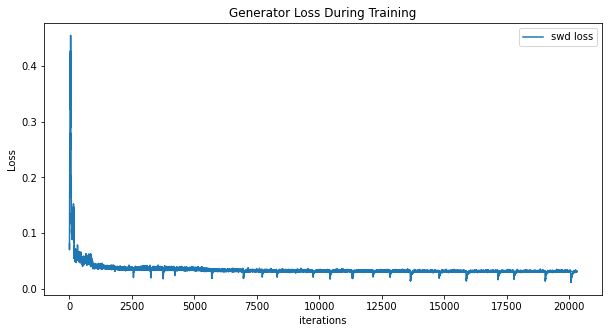

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses,label="swd loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Real Images vs. Fake Images**




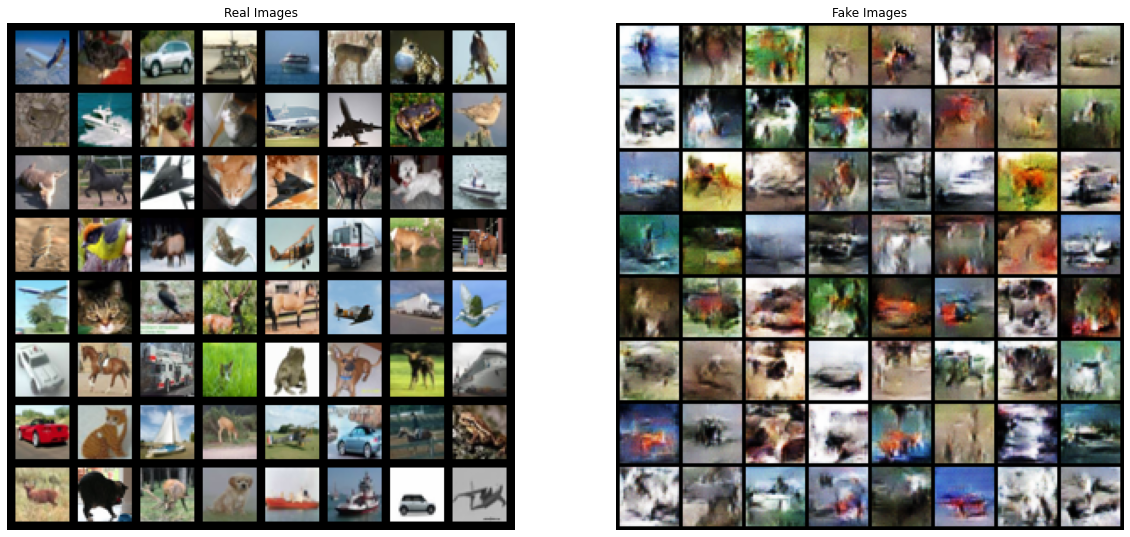

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last iteration
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Task 2: Show the effect of sample size by producing loss values on different sample sizes, as in Figure 4 in the paper.

**Difficulties Encountered**:
1. In Section 4.1, there is not any information about the fully connected generator architecture and hyperparameters. Therefore, we used the generator architecture from Appendix D of the paper but this architecture is not for the Section 4.1. We tried different architectures and hyperparameters but could not reach the same results as in the paper.

In [17]:
batch_size=64
z=32
num_iters=20000
lr=0.0005
beta1=0.5
num_projections=10000

## Training Data

The MNIST training dataset can be downloaded.

In [19]:
dataset_mnist = torchvision.datasets.MNIST(root=datadir,train=True, download=True,
                           transform=transforms.ToTensor()
                           ) 

dataloader_mnist = torch.utils.data.DataLoader(dataset_mnist, batch_size=1024,
                                         shuffle=False)

This batch consist of 1024 training images. There are four different configuration of training. First configuration uses the first 128 samples. Second one uses the first 256 samples. Third one uses first 512 samples and the last one uses 1024 samples.

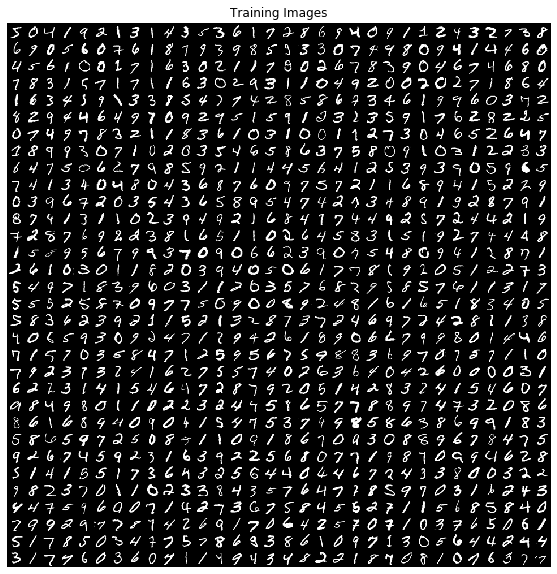

In [20]:
real_batch = next(iter(dataloader_mnist))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device),nrow=32, padding=2).cpu(),(1,2,0)))

### Fully Connected Generator
Generator architecture used in the paper is not expressed. So that we decided to use the generator architecture from Appendix D of the paper but this architecture is not for the Section 4.1.

In [21]:
class Gen_mnist(nn.Module):
    def __init__(self):
        super(Gen_mnist, self).__init__()
        self.net=nn.Sequential(
            nn.Linear(z, 512),
            nn.ReLU(True),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,784),
            nn.Sigmoid()
        )
    def forward(self, x):
        output=self.net(x)
        return output

**Plot pre-computed qualitative results**

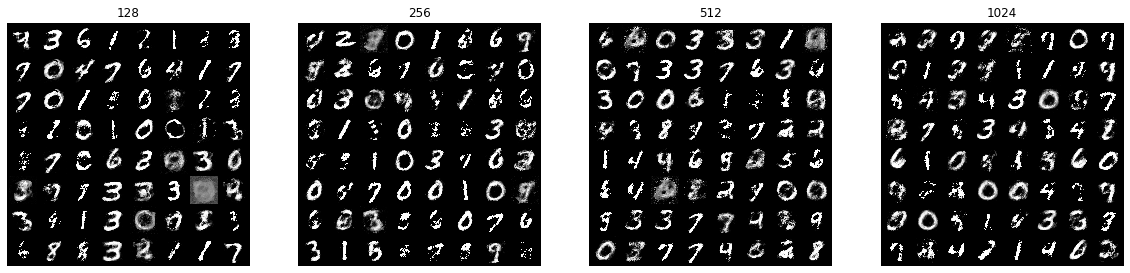

In [22]:
G128_img= torch.load(f"{out_file}/G128_img.pt")
G256_img= torch.load(f"{out_file}/G256_img.pt")
G512_img= torch.load(f"{out_file}/G512_img.pt")
G1024_img= torch.load(f"{out_file}/G1024_img.pt")

plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("128")
plt.imshow(np.transpose(G128_img[-1],(1,2,0)))

plt.subplot(1,4,2)
plt.axis("off")
plt.title("256")
plt.imshow(np.transpose(G256_img[-1],(1,2,0)))

plt.subplot(1,4,3)
plt.axis("off")
plt.title("512")
plt.imshow(np.transpose(G512_img[-1],(1,2,0)))

plt.subplot(1,4,4)
plt.axis("off")
plt.title("1024")
plt.imshow(np.transpose(G1024_img[-1],(1,2,0)))

plt.show()

**Plot losses of pre-computed models**

You can compare results with Figure 4 in the paper. Fully connected generator and hyperparameters used in the paper to produce Figure 4 is not expressed. So that we could not produce the same results.

Each configuration is trained 5 times with randomly set seeds, and the averages with error bars are presented.

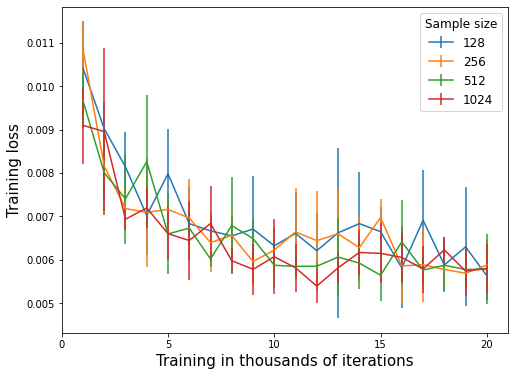

In [0]:
G128_losses= torch.load(f"{out_file}/G128_losses.pt")
G256_losses= torch.load(f"{out_file}/G256_losses.pt")
G512_losses= torch.load(f"{out_file}/G512_losses.pt")
G1024_losses= torch.load(f"{out_file}/G1024_losses.pt")

avg128=np.mean(G128_losses, axis=0)
err128= np.std(G128_losses, axis=0)
avg256=np.mean(G256_losses, axis=0)
err256= np.std(G256_losses, axis=0)
avg512=np.mean(G512_losses, axis=0)
err512= np.std(G512_losses, axis=0)
avg1024=np.mean(G1024_losses, axis=0)
err1024= np.std(G1024_losses, axis=0)

x=np.arange(1,21)

fig = plt.figure(figsize=(8,6))
plt.xlim(1,21)
plt.xticks(np.arange(0,21,5))
plt.errorbar(x, avg128, yerr=err128, label='128')
plt.errorbar(x, avg256, yerr=err256, label='256')
plt.errorbar(x, avg512, yerr=err512, label='512')
plt.errorbar(x, avg1024, yerr=err1024, label='1024')
plt.ylabel('Training loss', fontsize=15)
plt.xlabel('Training in thousands of iterations', fontsize=15)
plt.legend(title='Sample size',title_fontsize='large', fontsize='large')
plt.show()

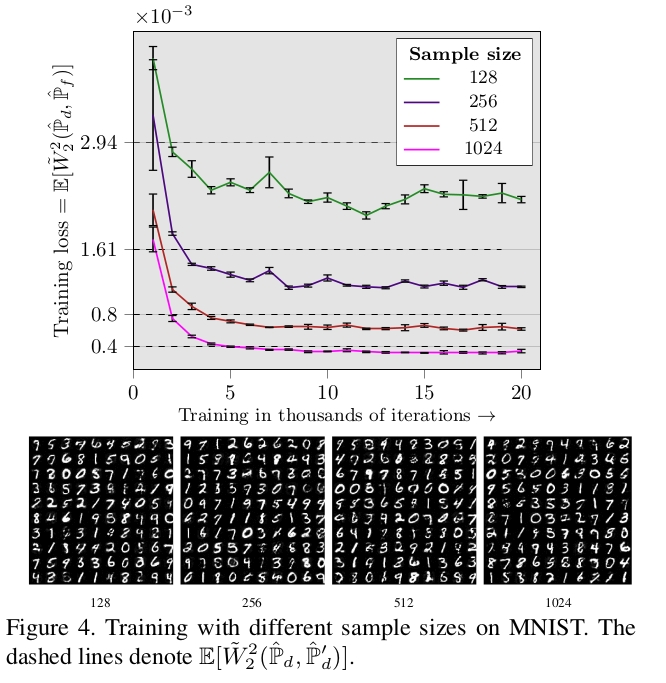

### Training


**Training of the model whose sample size is 128**

Each configuration is trained 5 times with randomly set
seeds, and the averages with error bars are presented.

In [0]:


#to store loss values for 5 times and 20 epochs
G128_losses=np.empty((5,20), dtype=float)
G128_img=[]

# train 5 times
for i in range(5):
    G128= Gen_mnist().to(device)
    optimizerG128 = optim.Adam(G128.parameters(), lr=lr, betas=(beta1, 0.999))
    for x in range(num_iters+1):
        # select random 64 samples from first 128 samples
        real_input=real_batch[0][np.random.randint(0, 128, batch_size)].to(device)
        G128.train()
        noise = torch.randn(batch_size, z).to(device)
        optimizerG128.zero_grad()
        fake = G128(noise)
        errG = swd_loss(real_input.view(batch_size, -1), fake)
        errG.backward()
        optimizerG128.step()
    
        if (x % 1000 == 0) and (x!=0):
          y=int(x/1000)-1
          G128_losses[i][y]= errG.item()
        if x % 5000==0:
          print('[%d/%d][%d] \t Loss_G: %.4f ' % (x, num_iters, i+1,  errG.item()))
    
    fixed_noise = torch.randn(batch_size, z).to(device)
    with torch.no_grad():
      fake = G128(fixed_noise).detach().cpu()
      G128_img.append(vutils.make_grid(fake.view(batch_size,1,28,28), padding=2))
    
torch.save(G128_losses, f"{out_file}/G128_losses.pt")
torch.save(G128_img, f"{out_file}/G128_img.pt")



[0/20000][1] 	 Loss_G: 0.2313 
[5000/20000][1] 	 Loss_G: 0.0078 
[10000/20000][1] 	 Loss_G: 0.0061 
[15000/20000][1] 	 Loss_G: 0.0070 
[20000/20000][1] 	 Loss_G: 0.0048 
[0/20000][2] 	 Loss_G: 0.2295 
[5000/20000][2] 	 Loss_G: 0.0070 
[10000/20000][2] 	 Loss_G: 0.0061 
[15000/20000][2] 	 Loss_G: 0.0075 
[20000/20000][2] 	 Loss_G: 0.0058 
[0/20000][3] 	 Loss_G: 0.2345 
[5000/20000][3] 	 Loss_G: 0.0093 
[10000/20000][3] 	 Loss_G: 0.0064 
[15000/20000][3] 	 Loss_G: 0.0059 
[20000/20000][3] 	 Loss_G: 0.0060 
[0/20000][4] 	 Loss_G: 0.2313 
[5000/20000][4] 	 Loss_G: 0.0068 
[10000/20000][4] 	 Loss_G: 0.0059 
[15000/20000][4] 	 Loss_G: 0.0063 
[20000/20000][4] 	 Loss_G: 0.0052 
[0/20000][5] 	 Loss_G: 0.2322 
[5000/20000][5] 	 Loss_G: 0.0091 
[10000/20000][5] 	 Loss_G: 0.0071 
[15000/20000][5] 	 Loss_G: 0.0066 
[20000/20000][5] 	 Loss_G: 0.0064 


**Training of the model whose sample size is 256**

In [0]:
#to store loss values for 5 times and 20 epochs
G256_losses=np.empty((5,20), dtype=float)
G256_img=[]

# train 5 times
for i in range(5):
    G256= Gen_mnist().to(device)
    optimizerG256 = optim.Adam(G256.parameters(), lr=lr, betas=(beta1, 0.999))
    for x in range(num_iters+1):
        # select random 64 samples from first 256 samples
        real_input=real_batch[0][np.random.randint(0, 256, batch_size)].to(device)
        G256.train()
        noise = torch.randn(batch_size, z).to(device)
        optimizerG256.zero_grad()
        fake = G256(noise)
        errG = swd_loss(real_input.view(batch_size, -1), fake)
        errG.backward()
        optimizerG256.step()
    
        if (x % 1000 == 0) and (x!=0):
          y=int(x/1000)-1
          G256_losses[i][y]= errG.item()
        if x % 5000==0:
          print('[%d/%d][%d] \t Loss_G: %.4f ' % (x, num_iters, i+1,  errG.item()))
    
    fixed_noise = torch.randn(batch_size, z).to(device)
    with torch.no_grad():
      fake = G256(fixed_noise).detach().cpu()
      G256_img.append(vutils.make_grid(fake.view(batch_size,1,28,28), padding=2))
    
torch.save(G256_losses, f"{out_file}/G256_losses.pt")
torch.save(G256_img, f"{out_file}/G256_img.pt")

[0/20000][1] 	 Loss_G: 0.2317 
[5000/20000][1] 	 Loss_G: 0.0074 
[10000/20000][1] 	 Loss_G: 0.0060 
[15000/20000][1] 	 Loss_G: 0.0074 
[20000/20000][1] 	 Loss_G: 0.0061 
[0/20000][2] 	 Loss_G: 0.2306 
[5000/20000][2] 	 Loss_G: 0.0067 
[10000/20000][2] 	 Loss_G: 0.0067 
[15000/20000][2] 	 Loss_G: 0.0076 
[20000/20000][2] 	 Loss_G: 0.0064 
[0/20000][3] 	 Loss_G: 0.2325 
[5000/20000][3] 	 Loss_G: 0.0069 
[10000/20000][3] 	 Loss_G: 0.0065 
[15000/20000][3] 	 Loss_G: 0.0068 
[20000/20000][3] 	 Loss_G: 0.0053 
[0/20000][4] 	 Loss_G: 0.2260 
[5000/20000][4] 	 Loss_G: 0.0074 
[10000/20000][4] 	 Loss_G: 0.0053 
[15000/20000][4] 	 Loss_G: 0.0066 
[20000/20000][4] 	 Loss_G: 0.0050 
[0/20000][5] 	 Loss_G: 0.2323 
[5000/20000][5] 	 Loss_G: 0.0074 
[10000/20000][5] 	 Loss_G: 0.0066 
[15000/20000][5] 	 Loss_G: 0.0065 
[20000/20000][5] 	 Loss_G: 0.0066 


**Training of the model whose sample size is 512**

In [0]:
#to store loss values for 5 times and 20 epochs
G512_losses=np.empty((5,20), dtype=float)
G512_img=[]

# train 5 times
for i in range(5):
    G512= Gen_mnist().to(device)
    optimizerG512 = optim.Adam(G512.parameters(), lr=lr, betas=(beta1, 0.999))
    for x in range(num_iters+1):
        # select random 64 samples from first 512 samples
        real_input=real_batch[0][np.random.randint(0, 512, batch_size)].to(device)
        G512.train()
        noise = torch.randn(batch_size, z).to(device)
        optimizerG512.zero_grad()
        fake = G512(noise)
        errG = swd_loss(real_input.view(batch_size, -1), fake)
        errG.backward()
        optimizerG512.step()
    
        if (x % 1000 == 0) and (x!=0):
          y=int(x/1000)-1
          G512_losses[i][y]= errG.item()
        if x % 5000==0:
          print('[%d/%d][%d] \t Loss_G: %.4f ' % (x, num_iters, i+1,  errG.item()))
    
    fixed_noise = torch.randn(batch_size, z).to(device)
    with torch.no_grad():
      fake = G512(fixed_noise).detach().cpu()
      G512_img.append(vutils.make_grid(fake.view(batch_size,1,28,28), padding=2))
    
torch.save(G512_losses, f"{out_file}/G512_losses.pt")
torch.save(G512_img, f"{out_file}/G512_img.pt")

[0/20000][1] 	 Loss_G: 0.2305 
[5000/20000][1] 	 Loss_G: 0.0056 
[10000/20000][1] 	 Loss_G: 0.0061 
[15000/20000][1] 	 Loss_G: 0.0064 
[20000/20000][1] 	 Loss_G: 0.0050 
[0/20000][2] 	 Loss_G: 0.2369 
[5000/20000][2] 	 Loss_G: 0.0058 
[10000/20000][2] 	 Loss_G: 0.0051 
[15000/20000][2] 	 Loss_G: 0.0050 
[20000/20000][2] 	 Loss_G: 0.0050 
[0/20000][3] 	 Loss_G: 0.2297 
[5000/20000][3] 	 Loss_G: 0.0066 
[10000/20000][3] 	 Loss_G: 0.0056 
[15000/20000][3] 	 Loss_G: 0.0062 
[20000/20000][3] 	 Loss_G: 0.0067 
[0/20000][4] 	 Loss_G: 0.2361 
[5000/20000][4] 	 Loss_G: 0.0068 
[10000/20000][4] 	 Loss_G: 0.0067 
[15000/20000][4] 	 Loss_G: 0.0058 
[20000/20000][4] 	 Loss_G: 0.0054 
[0/20000][5] 	 Loss_G: 0.2308 
[5000/20000][5] 	 Loss_G: 0.0082 
[10000/20000][5] 	 Loss_G: 0.0058 
[15000/20000][5] 	 Loss_G: 0.0050 
[20000/20000][5] 	 Loss_G: 0.0068 


**Training of the model whose sample size is 1024**

In [0]:
#to store loss values for 5 times and 20 epochs
G1024_losses=np.empty((5,20), dtype=float)
G1024_img=[]

# train 5 times
for i in range(5):
    G1024= Gen_mnist().to(device)
    optimizerG1024 = optim.Adam(G1024.parameters(), lr=lr, betas=(beta1, 0.999))
    for x in range(num_iters+1):
        # select random 64 samples from 1024 samples
        real_input=real_batch[0][np.random.randint(0, 1024, batch_size)].to(device)
        G1024.train()
        noise = torch.randn(batch_size, z).to(device)
        optimizerG1024.zero_grad()
        fake = G1024(noise)
        errG = swd_loss(real_input.view(batch_size, -1), fake)
        errG.backward()
        optimizerG1024.step()
    
        if (x % 1000 == 0) and (x!=0):
          y=int(x/1000)-1
          G1024_losses[i][y]= errG.item()
        if x % 5000==0:
          print('[%d/%d][%d] \t Loss_G: %.4f ' % (x, num_iters, i+1,  errG.item()))
    
    fixed_noise = torch.randn(batch_size, z).to(device)
    with torch.no_grad():
      fake = G1024(fixed_noise).detach().cpu()
      G1024_img.append(vutils.make_grid(fake.view(batch_size,1,28,28), padding=2))
    
torch.save(G1024_losses, f"{out_file}/G1024_losses.pt")
torch.save(G1024_img, f"{out_file}/G1024_img.pt")

[0/20000][1] 	 Loss_G: 0.2325 
[5000/20000][1] 	 Loss_G: 0.0057 
[10000/20000][1] 	 Loss_G: 0.0077 
[15000/20000][1] 	 Loss_G: 0.0051 
[20000/20000][1] 	 Loss_G: 0.0054 
[0/20000][2] 	 Loss_G: 0.2333 
[5000/20000][2] 	 Loss_G: 0.0063 
[10000/20000][2] 	 Loss_G: 0.0052 
[15000/20000][2] 	 Loss_G: 0.0065 
[20000/20000][2] 	 Loss_G: 0.0061 
[0/20000][3] 	 Loss_G: 0.2292 
[5000/20000][3] 	 Loss_G: 0.0074 
[10000/20000][3] 	 Loss_G: 0.0057 
[15000/20000][3] 	 Loss_G: 0.0061 
[20000/20000][3] 	 Loss_G: 0.0067 
[0/20000][4] 	 Loss_G: 0.2308 
[5000/20000][4] 	 Loss_G: 0.0065 
[10000/20000][4] 	 Loss_G: 0.0056 
[15000/20000][4] 	 Loss_G: 0.0072 
[20000/20000][4] 	 Loss_G: 0.0057 
[0/20000][5] 	 Loss_G: 0.2285 
[5000/20000][5] 	 Loss_G: 0.0071 
[10000/20000][5] 	 Loss_G: 0.0062 
[15000/20000][5] 	 Loss_G: 0.0058 
[20000/20000][5] 	 Loss_G: 0.0051 


**Plot losses with different sample sizes on MNIST**

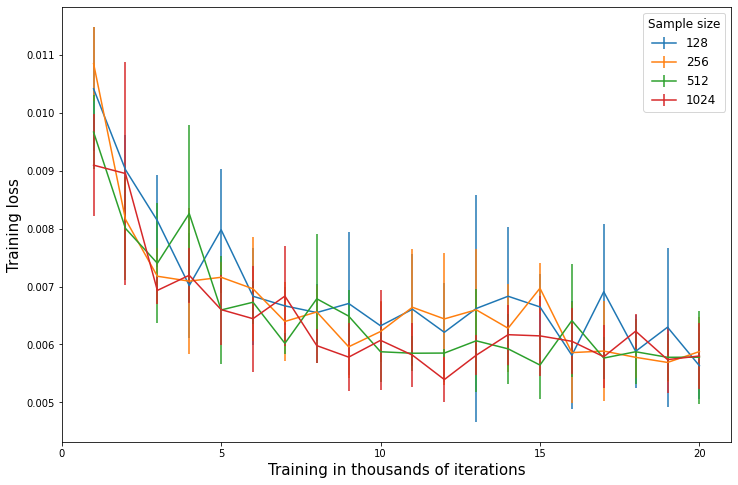

In [0]:
x=np.arange(1,21)

avg128=np.mean(G128_losses, axis=0)
err128= np.std(G128_losses, axis=0)
avg256=np.mean(G256_losses, axis=0)
err256= np.std(G256_losses, axis=0)
avg512=np.mean(G512_losses, axis=0)
err512= np.std(G512_losses, axis=0)
avg1024=np.mean(G1024_losses, axis=0)
err1024= np.std(G1024_losses, axis=0)

fig = plt.figure(figsize=(12,8))
plt.xlim(1,21)
plt.xticks(np.arange(0,21,5))
plt.errorbar(x, avg128, yerr=err128, label='128')
plt.errorbar(x, avg256, yerr=err256, label='256')
plt.errorbar(x, avg512, yerr=err512, label='512')
plt.errorbar(x, avg1024, yerr=err1024, label='1024')
plt.ylabel('Training loss', fontsize=15)
plt.xlabel('Training in thousands of iterations', fontsize=15)
plt.legend(title='Sample size',title_fontsize='large', fontsize='large')
plt.show()

**Plot fake images**

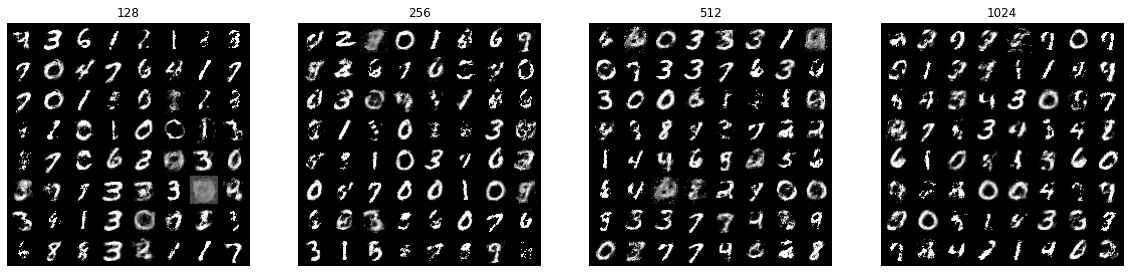

In [0]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("128")
plt.imshow(np.transpose(G128_img[-1],(1,2,0)))

plt.subplot(1,4,2)
plt.axis("off")
plt.title("256")
plt.imshow(np.transpose(G256_img[-1],(1,2,0)))

plt.subplot(1,4,3)
plt.axis("off")
plt.title("512")
plt.imshow(np.transpose(G512_img[-1],(1,2,0)))

plt.subplot(1,4,4)
plt.axis("off")
plt.title("1024")
plt.imshow(np.transpose(G1024_img[-1],(1,2,0)))

plt.show()